In [19]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
import os
import pandas as pd

In [20]:
BUILD_DATA = False

if BUILD_DATA == True:

  directory = 'sinus'
  filenames = os.listdir(directory)
  print(filenames)

  all_data = np.zeros((len(filenames),2000),dtype = np.float32)
  for i in range(len(filenames)):
    filename = filenames[i]
    print(filename)
    
    data=pd.read_csv(directory+'/'+filename)
    vars = ['sinus']
    data = data[vars]
    data = np.array(data)
    data = np.transpose(data)
    data = data[0]
        
    all_data[i] = data

  all_data = np.transpose(all_data) 
  np.save('data',all_data)


In [21]:
def create_dataset(dataset, lookback, step):
    dataX, dataY = [], []

    for i in range(len(dataset)-lookback-(step-1)):
        a = dataset[i:(i+lookback), :]
        dataX.append(a)
        dataY.append(dataset[i+lookback+(step-1), :])
    
    return np.array(dataX), np.array(dataY)

In [22]:
def load_data(filename, step, lookback):

    #load data from the data file
    data = np.load(filename)
    data = data[:, :]

    #data normalization
    max_data = np.max(data, axis = 0)
    min_data = np.min(data, axis = 0)
    max_data = np.reshape(max_data, (1, max_data.shape[0]))
    min_data = np.reshape(min_data, (1, min_data.shape[0]))
    data = (2 * data - (max_data + min_data)) / (max_data - min_data)

    #Create dataset
    dataX, dataY = create_dataset(data, lookback, step)

    #dataset split
    train_split = int(0.8 * dataX.shape[0])
    val_split = int(0.9 * dataX.shape[0])

    x_train = dataX[:train_split,:,:]
    y_train = dataY[:train_split,:]

    x_val = dataX[train_split:val_split,:,:]
    y_val = dataY[train_split:val_split,:]

    x_test = dataX[val_split:,:,:]
    y_test = dataY[val_split:,:]

    x_train = np.transpose(x_train, (0, 2, 1))
    x_val = np.transpose(x_val, (0, 2, 1))
    x_test = np.transpose(x_test, (0, 2, 1))

    return [x_train, y_train, x_val, y_val, x_test, y_test, max_data, min_data]


In [23]:
#Données apprentissage
data_file = 'dataBruit.npy'

#Prédiction n+step
step = 1

#Mémoire
lookback = 1

#Load data
X_train, y_train, X_val, y_val, X_test, y_test, max_data, min_data = load_data(data_file, step, lookback)


In [24]:
# Définition paramètres du réseau
n_cells = 12
n_epochs = 2000
n_batch = 6

In [25]:
# Construction du modèle 
model = Sequential()
model.add(LSTM(n_cells, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

#Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),loss="mean_squared_error")

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 12)             672       
                                                                 
 dense_4 (Dense)             (None, 3, 1)              13        
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [26]:
TRAINING = False
model_name = 'lstm_intro.hdf5'

if TRAINING == True : 

    checkpoint = ModelCheckpoint(filepath=model_name, monitor ='val_loss', verbose=1, save_best_only=True, mode='min')
    Enregistrement = model.fit(X_train, y_train, batch_size=n_batch, epochs=n_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])

    print(Enregistrement.history.keys())

    plt.figure(figsize=(16,8))
    loss_train = Enregistrement.history['loss']
    val_loss_train = Enregistrement.history['val_loss']
    plt.plot(loss_train,"b:o", label = "train_loss")
    plt.plot(val_loss_train,"r:o", label = "val_loss")
    plt.title("Loss and over training epochs")
    plt.legend()
    plt.show()

In [27]:
def plot_results(predicted_data, true_data):
    plt.plot(predicted_data, label='predicted')
    plt.plot(true_data, label='true data')
    plt.legend()
    plt.show()

(200, 3, 1)
The mean square error is: 0.272037


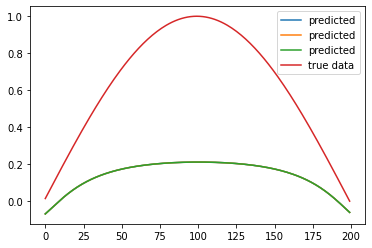

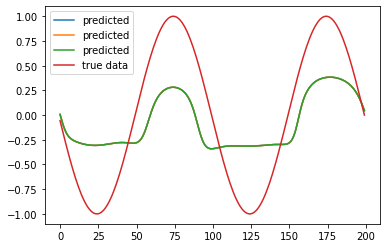

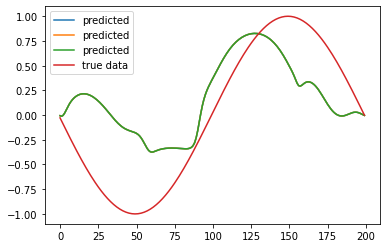

In [28]:
model = keras.models.load_model(model_name)

#Données test
data_file = 'data.npy'

#Prédiction n+step
step = 1

lookback = 1

X_train, y_train, X_val, y_val, X_test, y_test, max_data, min_data = load_data(data_file, step, lookback)

predicted = model.predict(X_test)

print(predicted.shape)

#dénormalization
prediction = (predicted[:,:,:] * (max_data - min_data) + (max_data + min_data))/2

error = np.sum((prediction[:,:,0] - y_test[:,:])**2) / (y_test.shape[0] * prediction.shape[1])
print('The mean square error is: %f' % error)
    
for ii in range(0, prediction.shape[1]):
    plot_results(prediction[:, ii], y_test[:, ii])